# Imports and setup

Want to rerun with smaller grid size for this stream since it is less long than GD-1. Is this something we have to change for each stream or is there a value that would be small enough for Pal 5 and still be ok for GD-1?

In [198]:
import astropy.table as at
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize

import sys
sys.path.append('/Users/Tavangar/Work/stream-membership/')
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

from scripts.m92_init import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

import os
import galstreams

In [2]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [451]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['scripts.m92_init'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from scripts.m92_init import *
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [ ]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)

sts = mws.get_track_names_for_stream('M92')


galstreams_dir = os.path.dirname(galstreams.__file__)
galstreams_tracks = os.path.join(galstreams_dir, "tracks/")
m92_i21 = galstreams.Track6D(stream_name='M92', track_name='M92-I21', 
                       track_file=galstreams_tracks + 'track.st.M92.ibata2021.ecsv', 
                       summary_file = galstreams_tracks + 'track.st.M92.ibata2021.summary.ecsv')
m92_i24 = galstreams.Track6D(stream_name='M92', track_name='M92-I24', 
                       track_file=galstreams_tracks + 'track.st.M92.ibata2024.ecsv', 
                       summary_file = galstreams_tracks + 'track.st.M92.ibata2024.summary.ecsv')
m92_s20 = galstreams.Track6D(stream_name='M92', track_name='M92-S20', 
                       track_file=galstreams_tracks + 'track.st.M92.sollima2020.ecsv', 
                       summary_file = galstreams_tracks + 'track.st.M92.sollima2020.summary.ecsv')
m92_t20 = galstreams.Track6D(stream_name='M92', track_name='M92-T20', 
                       track_file=galstreams_tracks + 'track.st.M92.thomas2020.ecsv', 
                       summary_file = galstreams_tracks + 'track.st.M92.thomas2020.summary.ecsv')
tracks = [m92_i21.track, m92_i24.track, m92_s20.track, m92_t20.track]
names = ['M92-I21', 'M92-I24', 'M92-S20', 'M92-T20']

In [327]:
m92_i24.track

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(250.96389115, 43.98791639, 1.), (250.98012429, 43.98874329, 1.),
     (250.99635611, 43.98956346, 1.), ..., (273.52972067, 36.36332753, 1.),
     (273.5386597 , 36.35415128, 1.), (273.54759329, 36.34497015, 1.)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-2.90467355, -2.15956614, 187.4558075 ),
     (-2.91096688, -2.15709109, 186.25950507),
     (-2.9172496 , -2.15461292, 185.06601581), ...,
     (-6.29183462,  1.93426912, -77.90982054),
     (-6.29461673,  1.93543249, -78.39199592),
     (-6.29740579,  1.93659459, -78.87615348)]>

In [326]:
gc.reflex_correct(m92_i24.track)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(250.96389115, 43.98791639, 1.), (250.98012429, 43.98874329, 1.),
     (250.99635611, 43.98956346, 1.), ..., (273.52972067, 36.36332753, 1.),
     (273.5386597 , 36.35415128, 1.), (273.54759329, 36.34497015, 1.)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(28.1994433 , 13.81816398, 369.30326592),
     (28.18847297, 13.81396546, 368.13811063),
     (28.17751114, 13.80977579, 366.9757518 ), ...,
     (16.09786983, 16.53270896, 133.02135177),
     (16.0908476 , 16.53892795, 132.5414253 ),
     (16.08382045, 16.54515164, 132.05949783)]>

In [330]:
data = at.Table.read("/Users/Tavangar/Work/CATS_Workshop/cats/data/joined-M92.fits")

In [331]:
fr = m92_i24.stream_frame

data['phi1'] = SkyCoord(ra = data['ra'] * u.deg, dec=data['dec']*u.deg, pm_ra_cosdec=data['pmra']*u.mas/u.yr, pm_dec = data['pmdec']*u.mas/u.yr).transform_to(fr).phi1.value
data['phi2'] = SkyCoord(ra = data['ra'] * u.deg, dec=data['dec']*u.deg, pm_ra_cosdec=data['pmra']*u.mas/u.yr, pm_dec = data['pmdec']*u.mas/u.yr).transform_to(fr).phi2.value
data['pm_phi1_cosphi2_unrefl'] = SkyCoord(ra = data['ra'] * u.deg, dec=data['dec']*u.deg, 
                       pm_ra_cosdec=data['pmra']*u.mas/u.yr, pm_dec = data['pmdec']*u.mas/u.yr).transform_to(fr).pm_phi1_cosphi2.value
data['pm_phi2_unrefl'] = SkyCoord(ra = data['ra'] * u.deg, dec=data['dec']*u.deg, 
                       pm_ra_cosdec=data['pmra']*u.mas/u.yr, pm_dec = data['pmdec']*u.mas/u.yr).transform_to(fr).pm_phi2.value

In [398]:
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

stream='M92'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-10,10]
phi2_lim = [-9, 6] # when working with Ibata 2024 until I get the larger box of data

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])]
cat = cat[(cat['phi2'] < phi2_lim[1]) & (cat['phi2'] > phi2_lim[0])]# clunky to hard code this

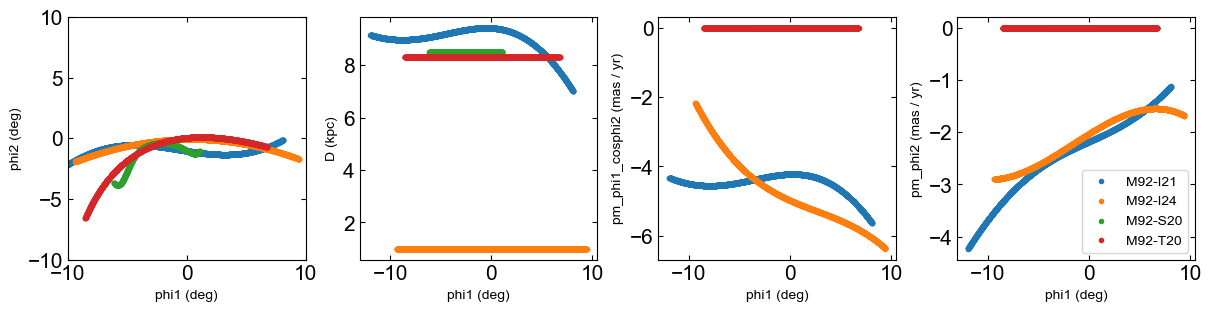

In [399]:
fig, axs = plt.subplots(1,4, figsize=(12,3), constrained_layout=True)
for i, track in enumerate(tracks):
    scat_kwds = dict(marker='.',label=names[i])
    galstreams.plot_5D_tracks_subplots_row(track, frame = fr, axs=axs, show_ylabels=True, scat_kwds=scat_kwds)
axs[0].set_ylim(-10,10) ; axs[0].set_xlim(-10,10)
plt.legend()
plt.show()

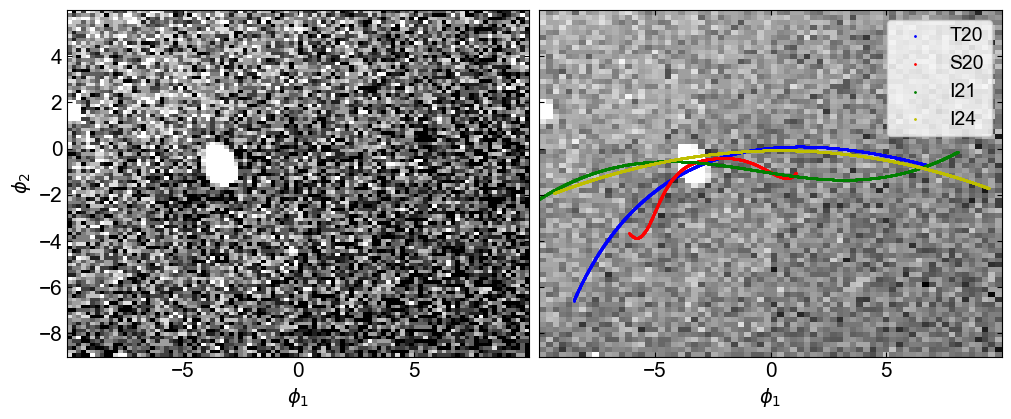

In [505]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax1.hist2d(run_data['phi1'], run_data['phi2'], cmap='gray_r', bins=[100,100], vmin=2, vmax=10)
ax2.hist2d(run_data['phi1'], run_data['phi2'], cmap='gray_r', bins=[70,70])
ax2.scatter(m92_t20.track.transform_to(fr).phi1, m92_t20.track.transform_to(fr).phi2, c='b', s=1, label='T20')
ax2.scatter(m92_s20.track.transform_to(fr).phi1, m92_s20.track.transform_to(fr).phi2, c='r', s=1, label='S20')
ax2.scatter(m92_i21.track.transform_to(fr).phi1, m92_i21.track.transform_to(fr).phi2, c='g', s=1, label='I21')
ax2.scatter(m92_i24.track.transform_to(fr).phi1, m92_i24.track.transform_to(fr).phi2, c='y', s=1, label='I24')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.legend(fontsize=14)
ax1.set_xlabel(r'$\phi_1$', fontsize=14)
ax1.set_ylabel(r'$\phi_2$', fontsize=14)
ax2.set_xlabel(r'$\phi_1$', fontsize=14)
plt.show()

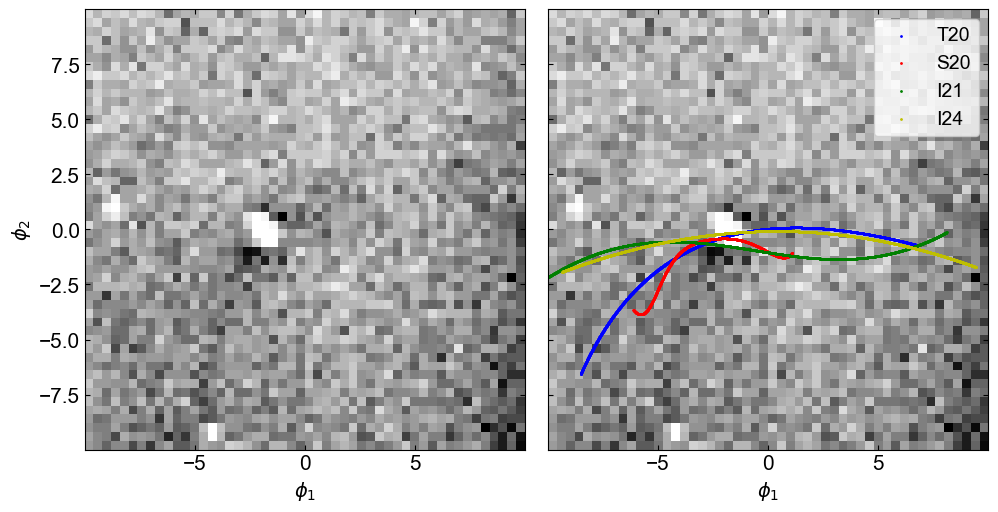

In [294]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax1.hist2d(run_data['phi1'], run_data['phi2'], cmap='gray_r', bins=[50,50])
ax2.hist2d(run_data['phi1'], run_data['phi2'], cmap='gray_r', bins=[50,50])
ax2.scatter(m92_t20.track.transform_to(fr).phi1, m92_t20.track.transform_to(fr).phi2, c='b', s=1, label='T20')
ax2.scatter(m92_s20.track.transform_to(fr).phi1, m92_s20.track.transform_to(fr).phi2, c='r', s=1, label='S20')
ax2.scatter(m92_i21.track.transform_to(fr).phi1, m92_i21.track.transform_to(fr).phi2, c='g', s=1, label='I21')
ax2.scatter(m92_i24.track.transform_to(fr).phi1, m92_i24.track.transform_to(fr).phi2, c='y', s=1, label='I24')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.legend(fontsize=14)
ax1.set_xlabel(r'$\phi_1$', fontsize=14)
ax1.set_ylabel(r'$\phi_2$', fontsize=14)
ax2.set_xlabel(r'$\phi_1$', fontsize=14)
plt.show()

In [506]:
m92_dict = dict(
                # galstream stuff
                short_name="M92",
                pawprint_id='ibata2024',
                #pawprint_id="thomas2020",
                # stream stuff
                width=2,  # TOTAL width degrees, recommend 2sigma if known
                # data stuff
                phot_survey="PS1",
                band1="g",
                band2="i",
                mag="g_0",
                color1="g_0",
                color2="i_0",
                minmag=16.0,
                maxmag=24.0,
                # isochrone stuff
                age=13.0,  # Gyr
                feh=-1.98,
                distance=8.5,  # kpc
                turnoff=14,  # bright limit of polygon (default should be MS turnoff)
                alpha=0,  # don't think we actually use this
                scale_err=2,
                base_err=0.075,
                bin_sizes=[0.03, 0.2],
            )

In [507]:
import importlib
importlib.reload(sys.modules['cats.pawprint.pawprint'])
importlib.reload(sys.modules['cats.CMD'])
importlib.reload(sys.modules['cats.proper_motions'])
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

p = Pawprint.pawprint_from_galstreams(m92_dict['short_name'],
                                      m92_dict['pawprint_id'],
                                      width=4 * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=1)

# Create the CMD cuts
o = Isochrone(cat, m92_dict, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track


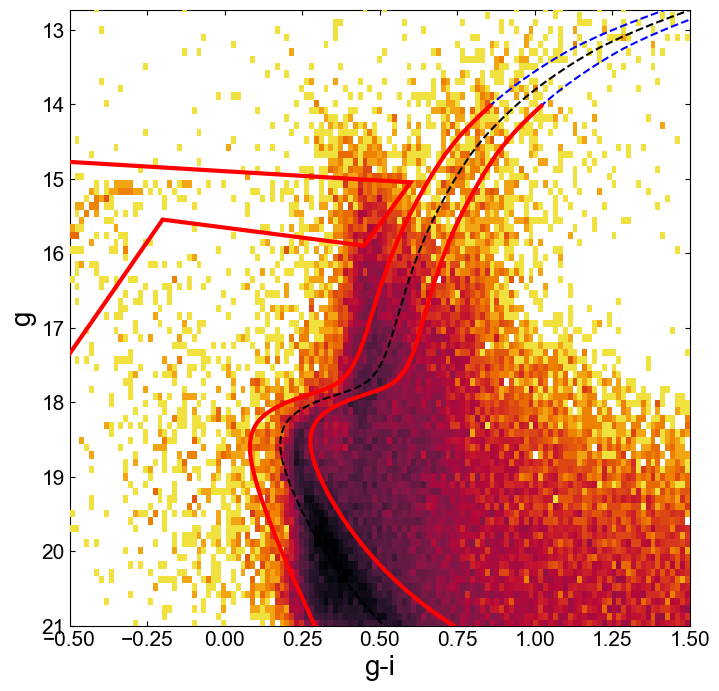

In [508]:
fig = o.plot_CMD()

0.03620100512248857
Fitting for peak pm location
Pre-fitting mean PM values: -4.984, -2.023
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-5.429855625490179, -1.391228078776296, 0.1825662748761158, 0.15581647057460815] 

Producing the polygon and mask


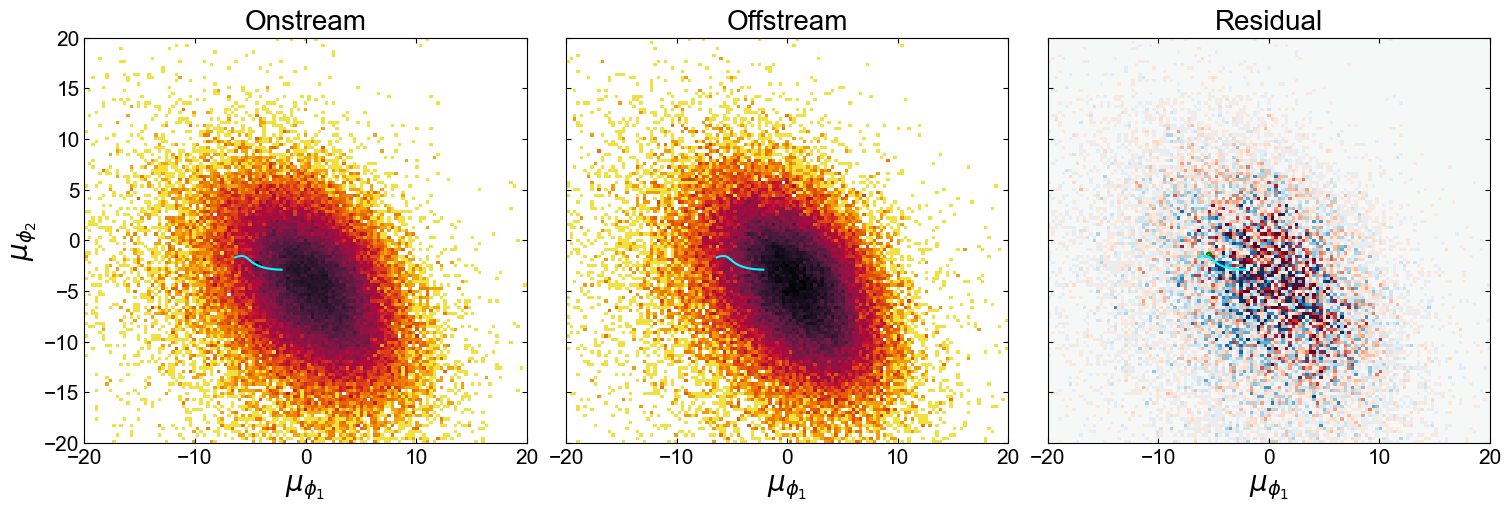

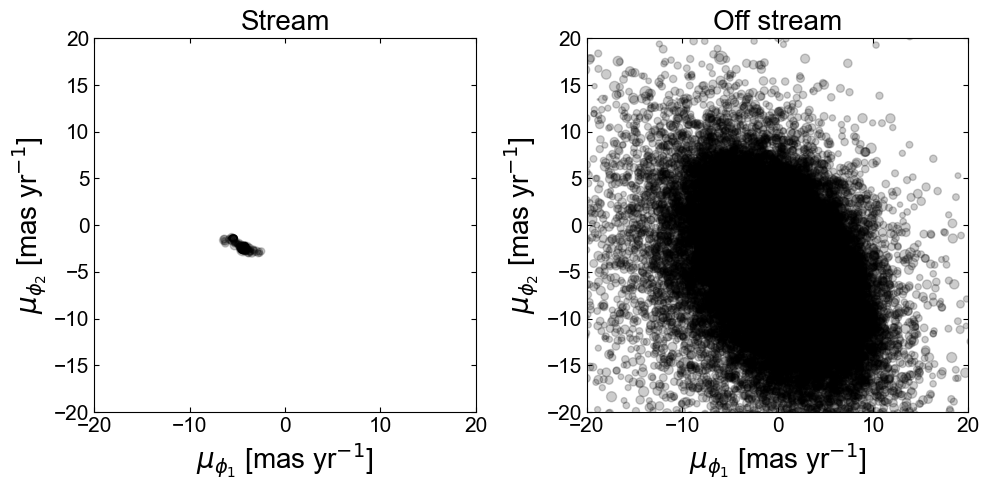

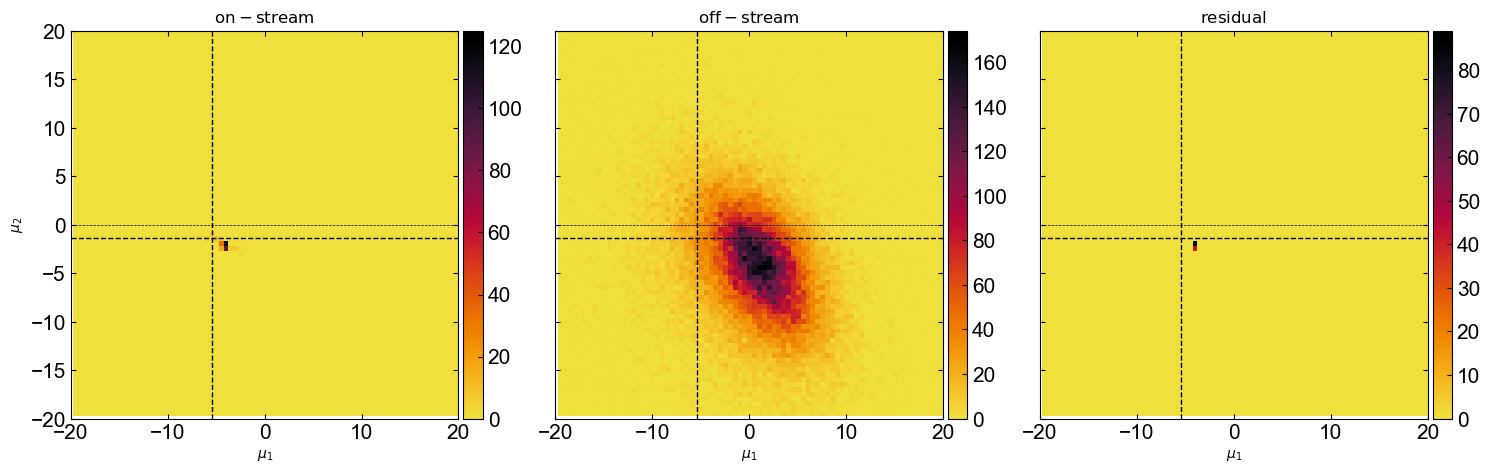

In [509]:
pmsel = ProperMotionSelection(cat, m92_dict, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1, plot=True)

In [514]:
o = Isochrone(cat, m92_dict, pawprint=pmsel.pawprint,)

_, iso_mask, _, hb_mask, pprint = o.simpleSln(22, mass_thresh=0.83)

In [517]:
o.y_shift

0.09999999999999964

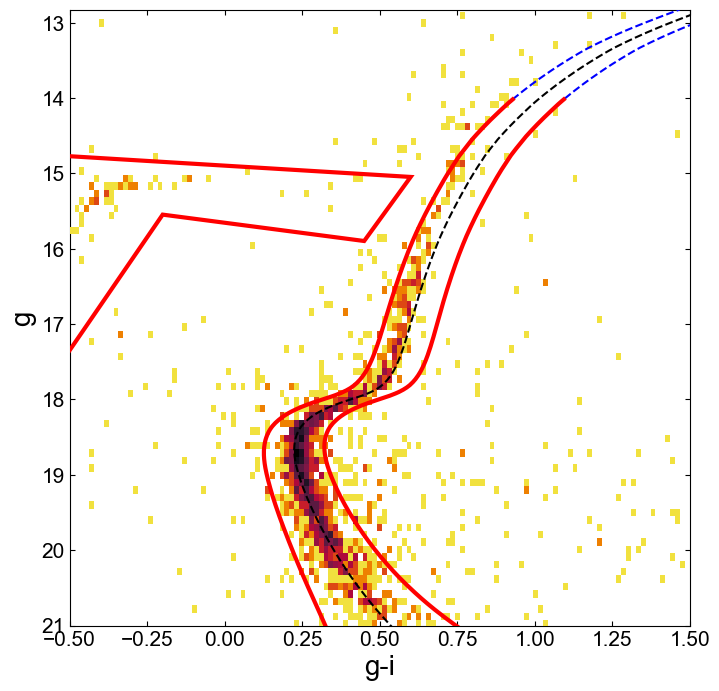

In [515]:
fig=o.plot_CMD()

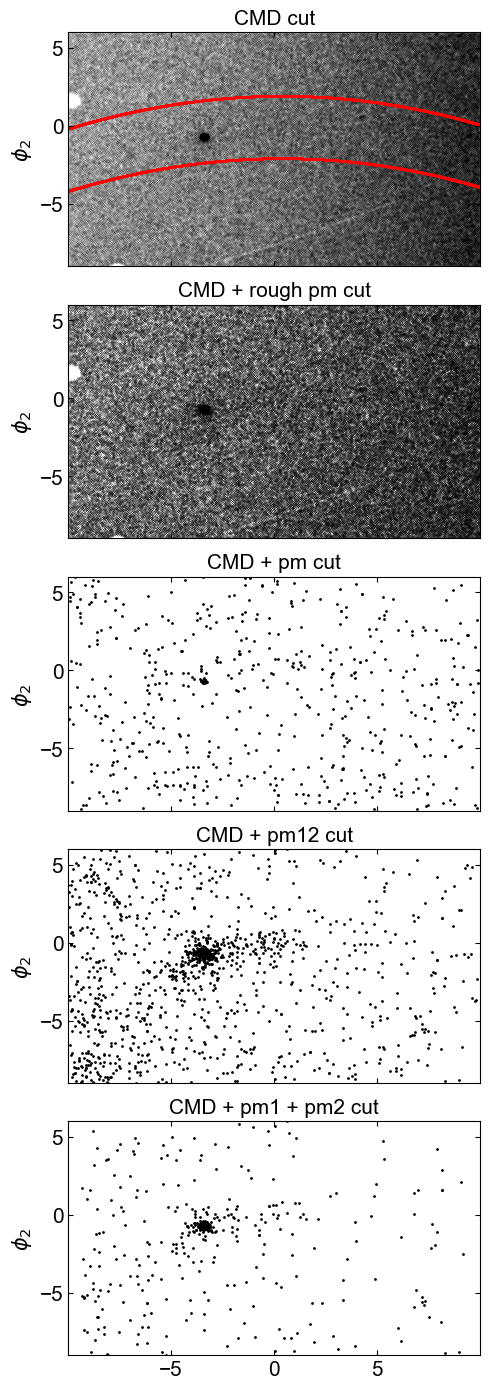

In [518]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(5, 14), sharex=True)

ax1.scatter(o.cat[iso_mask | hb_mask]['phi1'], 
            o.cat[iso_mask | hb_mask]['phi2'], s=0.001, c='k')
ax1.scatter(pprint.skyprint['stream'].vertices[:,0], 
            pprint.skyprint['stream'].vertices[:,1], s=1, c='r')
ax1.set_title('CMD cut', fontsize=15)

ax2.scatter(o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi1'], 
            o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi2'], s=0.01, c='k')
ax2.set_title('CMD + rough pm cut', fontsize=15)

ax3.scatter(o.cat[pmsel.pm_mask & (iso_mask | hb_mask)]['phi1'], 
            o.cat[pmsel.pm_mask & (iso_mask | hb_mask)]['phi2'], s=1, c='k')
ax3.set_title('CMD + pm cut', fontsize=15)

ax4.scatter(o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['phi1'], 
            o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['phi2'], s=1, c='k')
ax4.set_title('CMD + pm12 cut', fontsize=15)

ax5.scatter(o.cat[pmsel.pm1_mask & pmsel.pm2_mask & (iso_mask | hb_mask)]['phi1'], 
            o.cat[pmsel.pm1_mask & pmsel.pm2_mask & (iso_mask | hb_mask)]['phi2'], s=1, c='k')
ax5.set_title('CMD + pm1 + pm2 cut', fontsize=15)

# ax5.set_xlabel(r'$\phi_1$', fontsize=15)
ax1.set_ylabel(r'$\phi_2$', fontsize=15)
ax2.set_ylabel(r'$\phi_2$', fontsize=15)
ax3.set_ylabel(r'$\phi_2$', fontsize=15)
ax4.set_ylabel(r'$\phi_2$', fontsize=15)
ax5.set_ylabel(r'$\phi_2$', fontsize=15)

ax5.set_xlim(np.min(o.cat['phi1']), np.max(o.cat['phi1']))
ax1.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax2.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax3.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax4.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax5.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))

fig.tight_layout()
plt.show()

In [528]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=0)

In [590]:
import pandas as pd
all_gc_tbl = pd.read_csv('/Users/Tavangar/Work/CATS_workshop/cats/data/gc.txt', delim_whitespace=True)

m92_row = all_gc_tbl[all_gc_tbl['Cluster'] == 'NGC_6341']

delta = np.linalg.norm([np.abs(cat['ra'] - m92_row['RA'].values), np.abs(cat['dec'] - m92_row['DEC'].values)], axis=0)
m92_cluster_mask = delta < 0

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_41202/3797097033.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  all_gc_tbl = pd.read_csv('/Users/Tavangar/Work/CATS_workshop/cats/data/gc.txt', delim_whitespace=True)


In [591]:
m92_cluster_mask

array([False, False, False, ..., False, False, False])

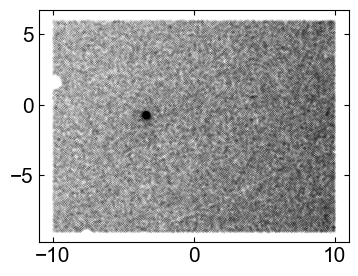

In [592]:
plt.figure(figsize=(4,4))
plt.scatter(o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]['phi1'],
            o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]['phi2'], s=0.001, c='k')
plt.gca().set_aspect('equal')
plt.show()

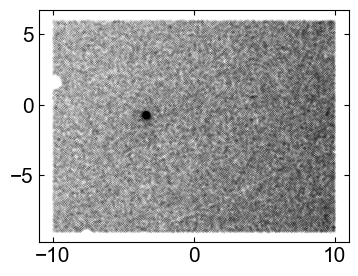

In [593]:
plt.figure(figsize=(4,4))
plt.scatter(o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi1'],
            o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi2'], s=0.001, c='k')
plt.gca().set_aspect('equal')
plt.show()

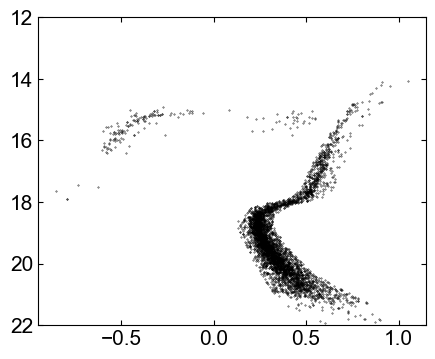

In [594]:
plt.figure(figsize=(5,4))
plt.scatter(o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['g_0'] - o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['i_0'],
            o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['g_0'], s=0.1, c='k')
plt.ylim(22,12)
plt.show()

In [595]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask & ~m92_cluster_mask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}


stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask  & ~m92_cluster_mask]
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

In [596]:
len(stream_data_)

4088

In [597]:
len(bkg_data_)

13926

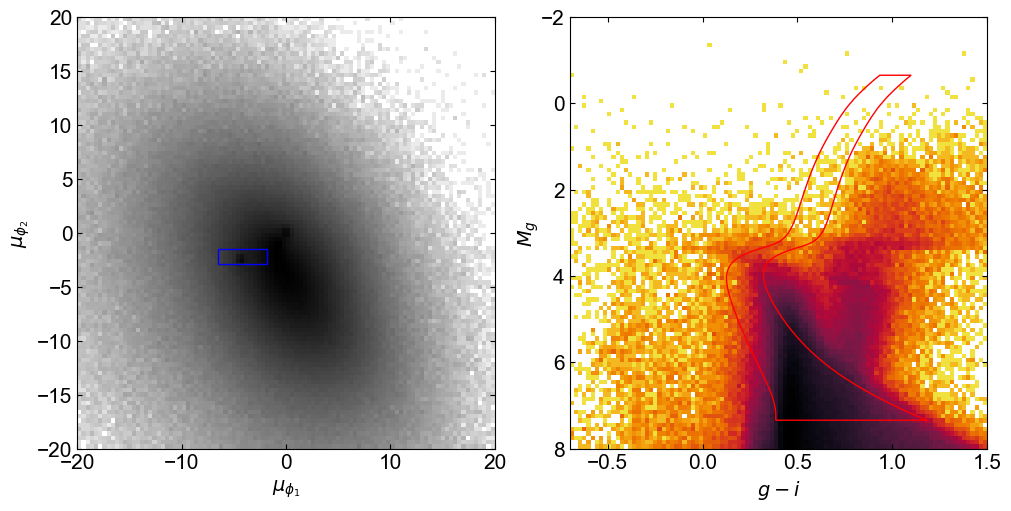

In [598]:
cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, edgecolor="red", facecolor="none")

pm_poly = o.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, edgecolor="blue", facecolor="none")

track = p.track.track.transform_to(p.track.stream_frame)
spline_dist = IUS(track.phi1.value, track.distance.value)
dist_mod_correct_all = (5 * np.log10(spline_dist(cat["phi1"]) * 1000) - 5) - o.dist_mod

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
ax1.hist2d(o.cat['pm1'], o.cat['pm2'], cmap='gray_r', bins=100, range=[[-20,20],[-20,20]], 
           norm=mpl.colors.LogNorm(), rasterized=True)
ax1.add_patch(pm_patch)
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

ax2.hist2d(o.cat['g_0'] - o.cat['i_0'], o.cat['g_0'] - dist_mod_correct_all  - o.dist_mod, 
           bins=100, range=[[-0.7,1.5],[-2,8]], norm=mpl.colors.LogNorm(), rasterized=True)
ax2.add_patch(cmd_patch)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)

ax1.set_xlabel(r'$\mu_{\phi_1}$', fontsize=14)
ax1.set_ylabel(r'$\mu_{\phi_2}$', fontsize=14)

ax2.set_xlabel(r'$g-i$', fontsize=14)
ax2.set_ylabel(r'$M_g$', fontsize=14, labelpad=0.1)
# plt.savefig('../../paper_figures/m92_cuts.pdf')
plt.show()

In [599]:
importlib.reload(sys.modules['scripts.m92_init'])
from scripts.m92_init import *

In [600]:
BkgModel = make_bkg_model(BackgroundModel, p, cat, knot_sep=5, phi2_bkg=True)

In [601]:
BkgModel._data_required

{'phi1': {'y': 'phi1', 'y_err': 'phi1_err'},
 'phi2': {'y': 'phi2', 'y_err': 'phi2_err'},
 'pm1': {'x': 'phi1', 'y': 'pm1', 'y_err': 'pm1_err'},
 'pm2': {'x': 'phi1', 'y': 'pm2', 'y_err': 'pm2_err'}}

In [602]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    "phi1": {'zs': np.zeros(BkgModel.phi1_locs.shape[0]-1)},
    "phi2": {'zs': np.zeros(BkgModel.phi2_locs.shape[0]-1)
        # 'mean':np.full_like(BkgModel.phi2_knots, -5),
        # 'ln_std': np.full_like(BkgModel.phi2_knots, 3),
    },
    "pm1": {
        "w": np.full_like(BkgModel.pm1_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm1_knots, 0),
        "ln_std1": np.full_like(BkgModel.pm1_knots, 1),
        "mean2": np.full_like(BkgModel.pm1_knots, -2),
        "ln_std2": np.full_like(BkgModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BkgModel.pm2_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm2_knots, -1.5),
        "ln_std1": np.full_like(BkgModel.pm2_knots, 1),
        "mean2": np.full_like(BkgModel.pm2_knots, 0),
        "ln_std2": np.full_like(BkgModel.pm2_knots, 2)
    },
}

background_init = BkgModel(bkg_init_p)

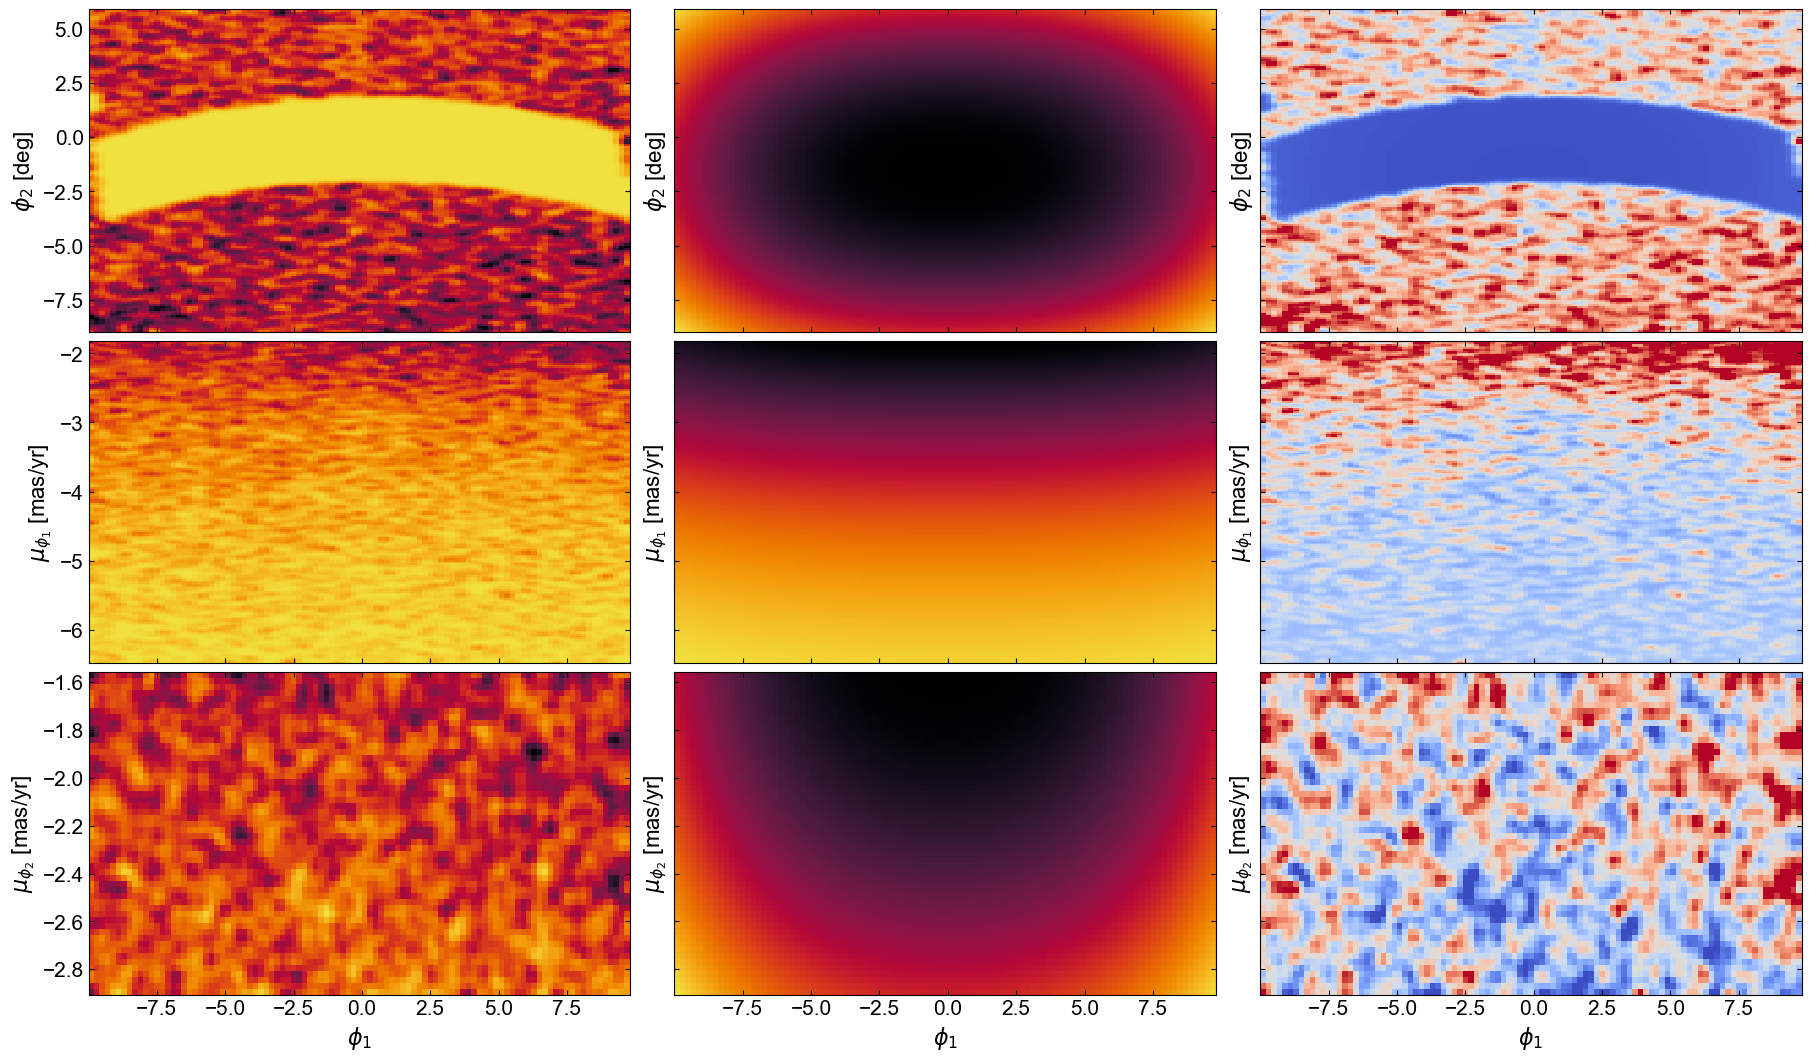

In [603]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

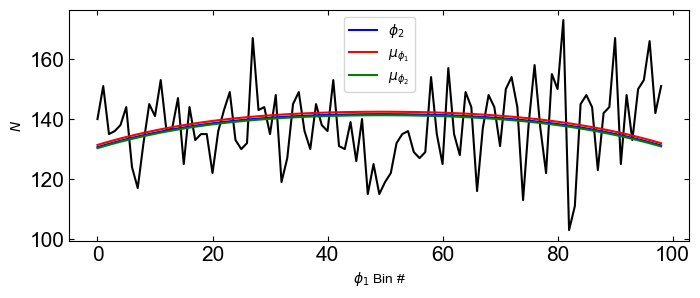

In [604]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [544]:
bkg_opt_pars, bkg_info = background_init.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)

background_opt = BkgModel(bkg_opt_pars)
bkg_info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.001455045465681256 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.001455045465681256 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:1.0  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 1.4019245143018368 Stepsize:0.5  Decrease Error:0.21276748402896065  Curvature Error:1.4019245143018368 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.26880846265643643 Stepsize:0.3245629281376407  Decrease Error:0.0  Curvature Error:0.26880846265643643 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.18099156234921007  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.2714873435238151  D

LbfgsbState(iter_num=Array(38, dtype=int64, weak_type=True), value=Array(-1.291383, dtype=float64), grad={'ln_N': Array(0.00093494, dtype=float64), 'phi1': {'zs': Array([ 0.00011193, -0.00028791, -0.00028109, -0.00024768, -0.00025526,
       -0.00029127], dtype=float64)}, 'phi2': {'zs': Array([1.53232310e-04, 4.63775934e-05, 2.62974937e-05, 3.89163966e-05,
       1.26175272e-04], dtype=float64)}, 'pm1': {'ln_std1': Array([-1.23532801e-05,  3.89514081e-04, -2.10047131e-04, -2.11709055e-04,
       -1.56441299e-04], dtype=float64), 'ln_std2': Array([2.00145552e-05, 2.14866786e-04, 1.92781327e-04, 3.26657209e-04,
       1.23288165e-04], dtype=float64), 'mean1': Array([-8.70321641e-06, -1.37458279e-04, -8.41248204e-05, -1.21161789e-04,
       -2.08519447e-05], dtype=float64), 'mean2': Array([-7.61928729e-06, -3.67237056e-05, -3.44881020e-05, -3.56676072e-05,
       -1.65813321e-05], dtype=float64), 'w': Array([-0.00020305, -0.00023353, -0.00027727, -0.00064087, -0.00051101],      dtype=floa

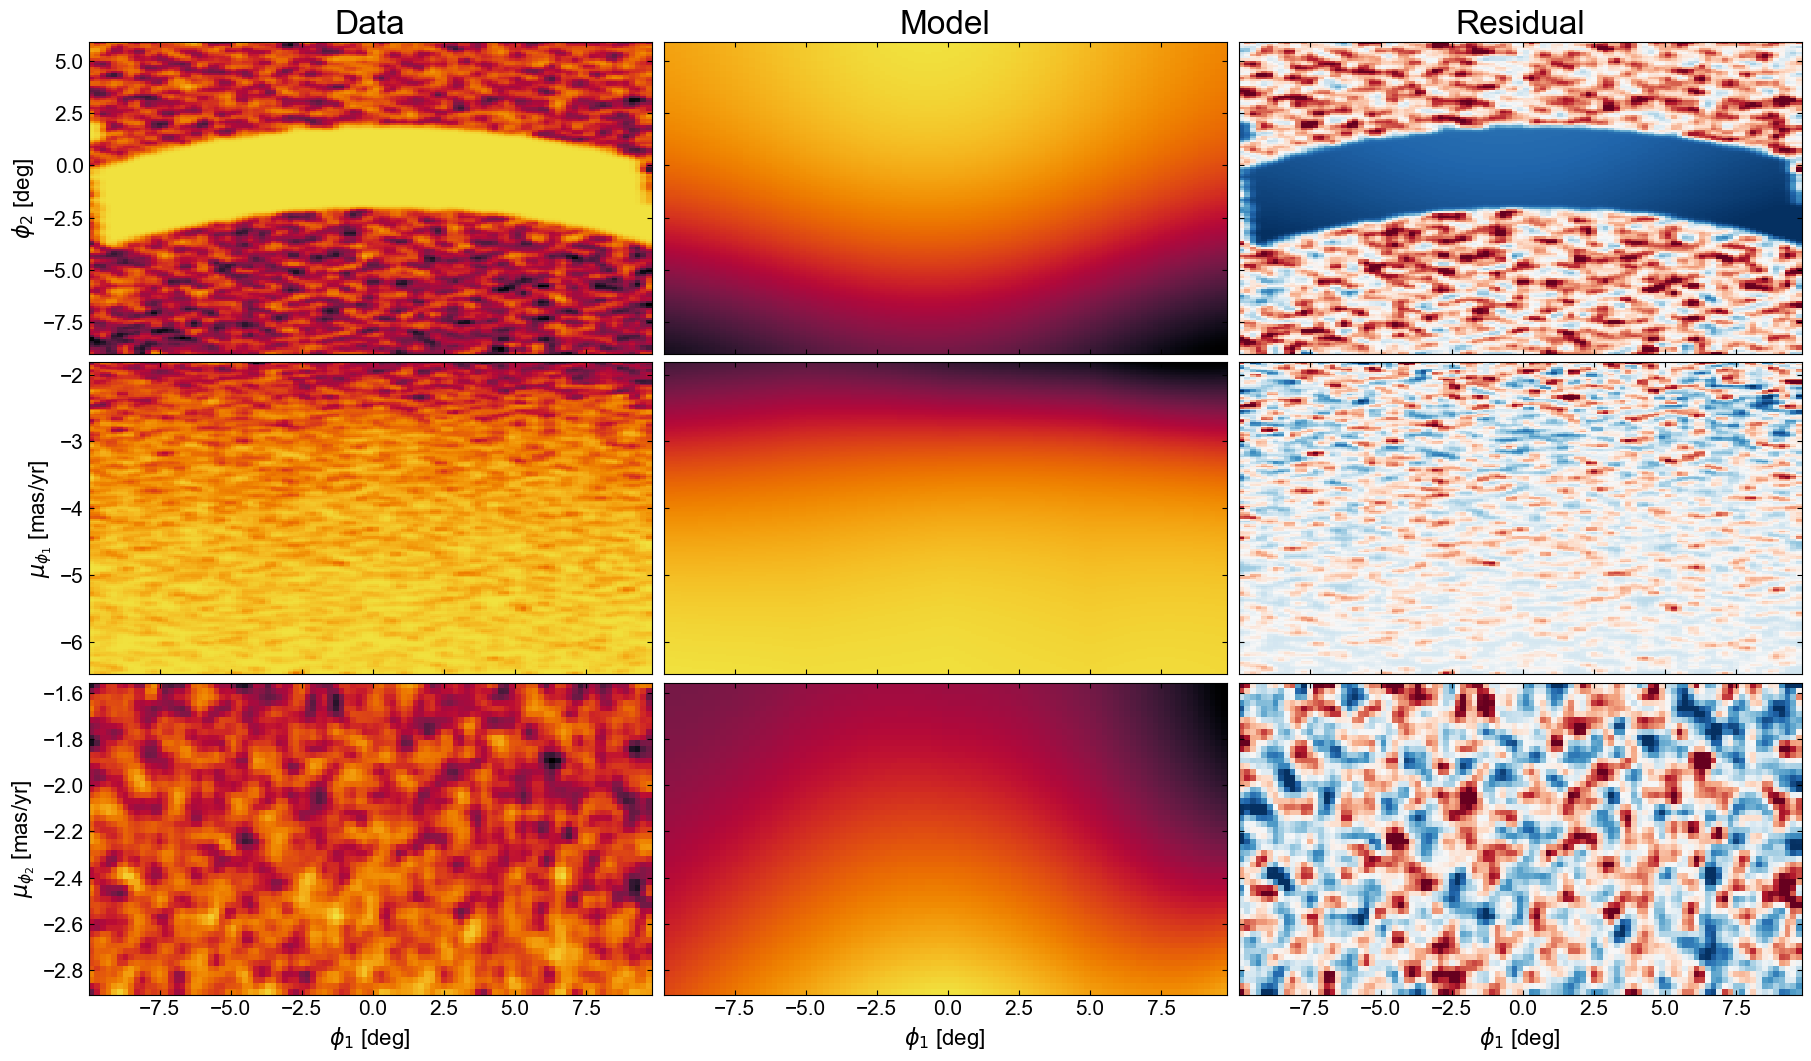

In [545]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True)
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True))
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

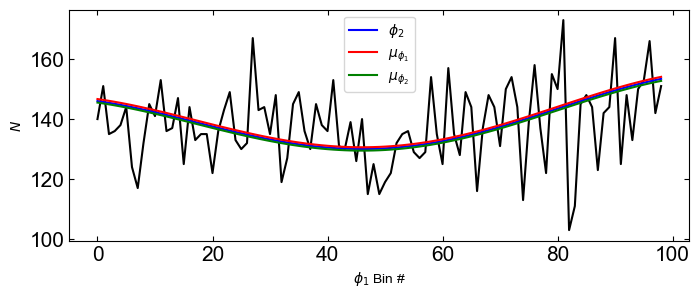

In [546]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)

grids, ln_ns = background_opt.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

# Stream

In [605]:
StrModel = make_stream_model(StreamDensModel, p, cat, knot_sep=1)

In [606]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=1
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=1
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=1
)

In [607]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [608]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, np.log(inputs[stream]['width']/2))
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -0.5)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -0.5)
    }
}

stream_init = StrModel(stream_init_p)

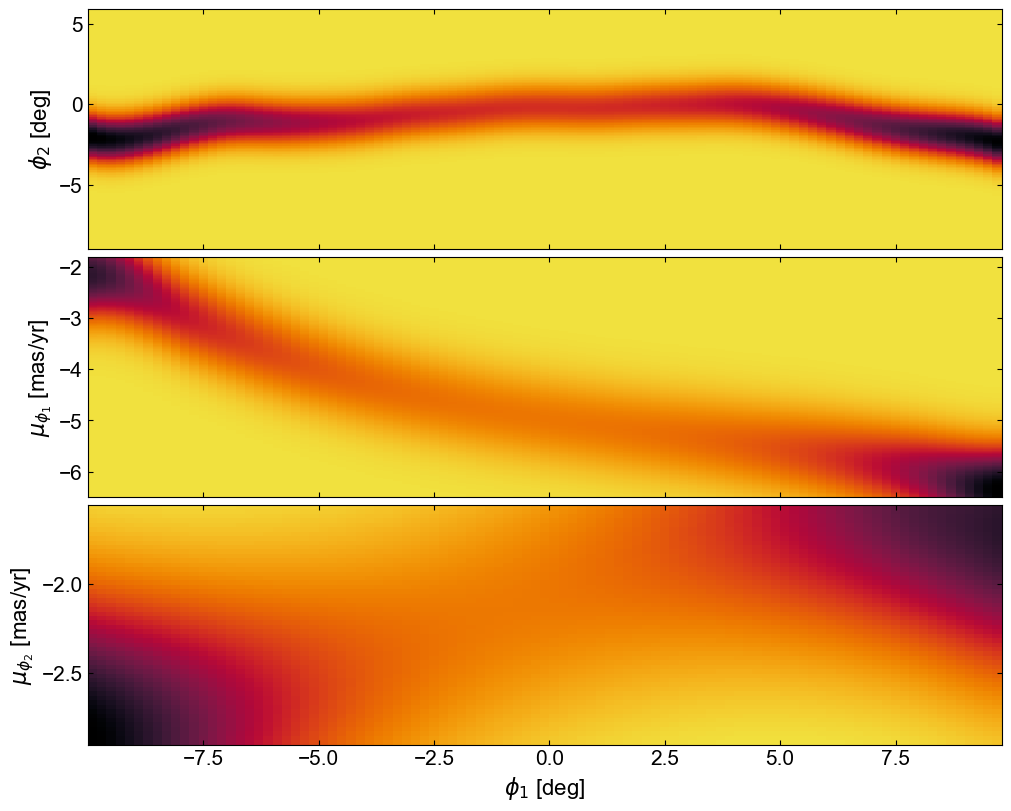

In [609]:
_ = stream_init.plot_model_projections()

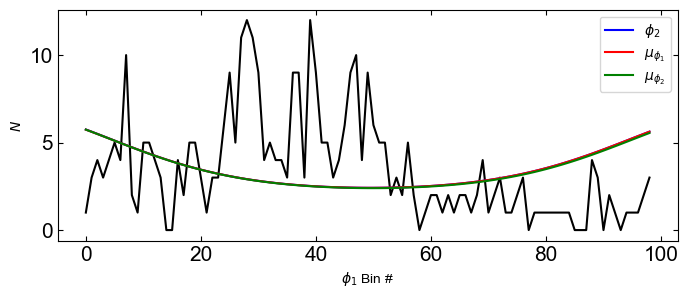

In [561]:
H_data1, *_ = np.histogram2d(
    stream_data["phi1"],
    stream_data["phi2"],
    bins=(stream_init.default_grids["phi1"], stream_init.default_grids['phi2'])
)

grids, ln_ns = stream_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [562]:
stream_opt_pars, info = stream_init.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True, jaxopt_kwargs=dict(maxiter=4096),
)

stream_opt = StrModel(stream_opt_pars)
info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.01188741760187495 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.01188741760187495 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 21.050079254075634 Stepsize:1.0  Decrease Error:3.1911502342329214  Curvature Error:21.050079254075634 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.21140137418063848  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.31710206127095775  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.2037195499761293 Stepsize:0.4756530919064366  Decrease Error:0.11396691046742932  Curvature Error:1.2037195499761293 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Ste

LbfgsbState(iter_num=Array(104, dtype=int64, weak_type=True), value=Array(-1.58043162, dtype=float64), grad={'ln_N': Array(6.43929354e-15, dtype=float64), 'phi1': {'zs': Array([-3.37520379e-04,  5.12485553e-05,  9.26596243e-04, -1.38762818e-04,
        1.20524615e-04,  1.54117165e-04,  1.00703589e-04], dtype=float64)}, 'phi2': {'ln_std': Array([ 2.26655317e-05, -1.47441295e-04,  5.66116650e-05, -9.40118947e-04,
       -3.71131753e-05,  1.45710754e-04, -8.78050895e-05,  3.93456358e-05,
        6.75422633e-05, -4.85930475e-05, -1.56874943e-04], dtype=float64), 'mean': Array([-1.47648252e-06, -7.77203357e-05,  7.31411889e-05,  2.97622022e-05,
       -4.64666606e-05,  2.66984564e-05,  1.07599955e-05,  2.32300435e-05,
       -6.05132804e-05, -1.01956064e-04, -5.82704623e-04], dtype=float64)}, 'pm1': {'ln_std': Array([ 2.87875182e-04,  5.19066228e-04, -2.69618379e-04,  3.94247797e-04,
        3.69633258e-04,  5.61846010e-05,  5.29964729e-05,  1.82775759e-04,
       -3.51223457e-04,  4.378187

Text(0, 0.5, '$\\phi_2$')

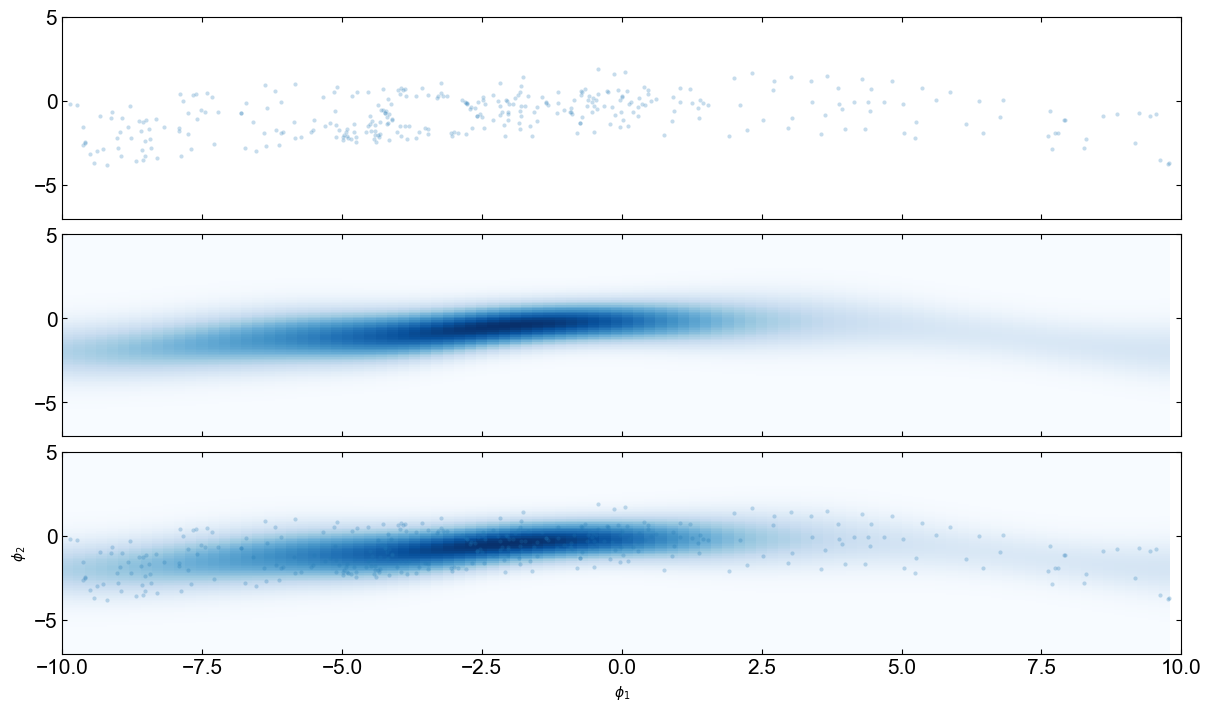

In [563]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-10, 10)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

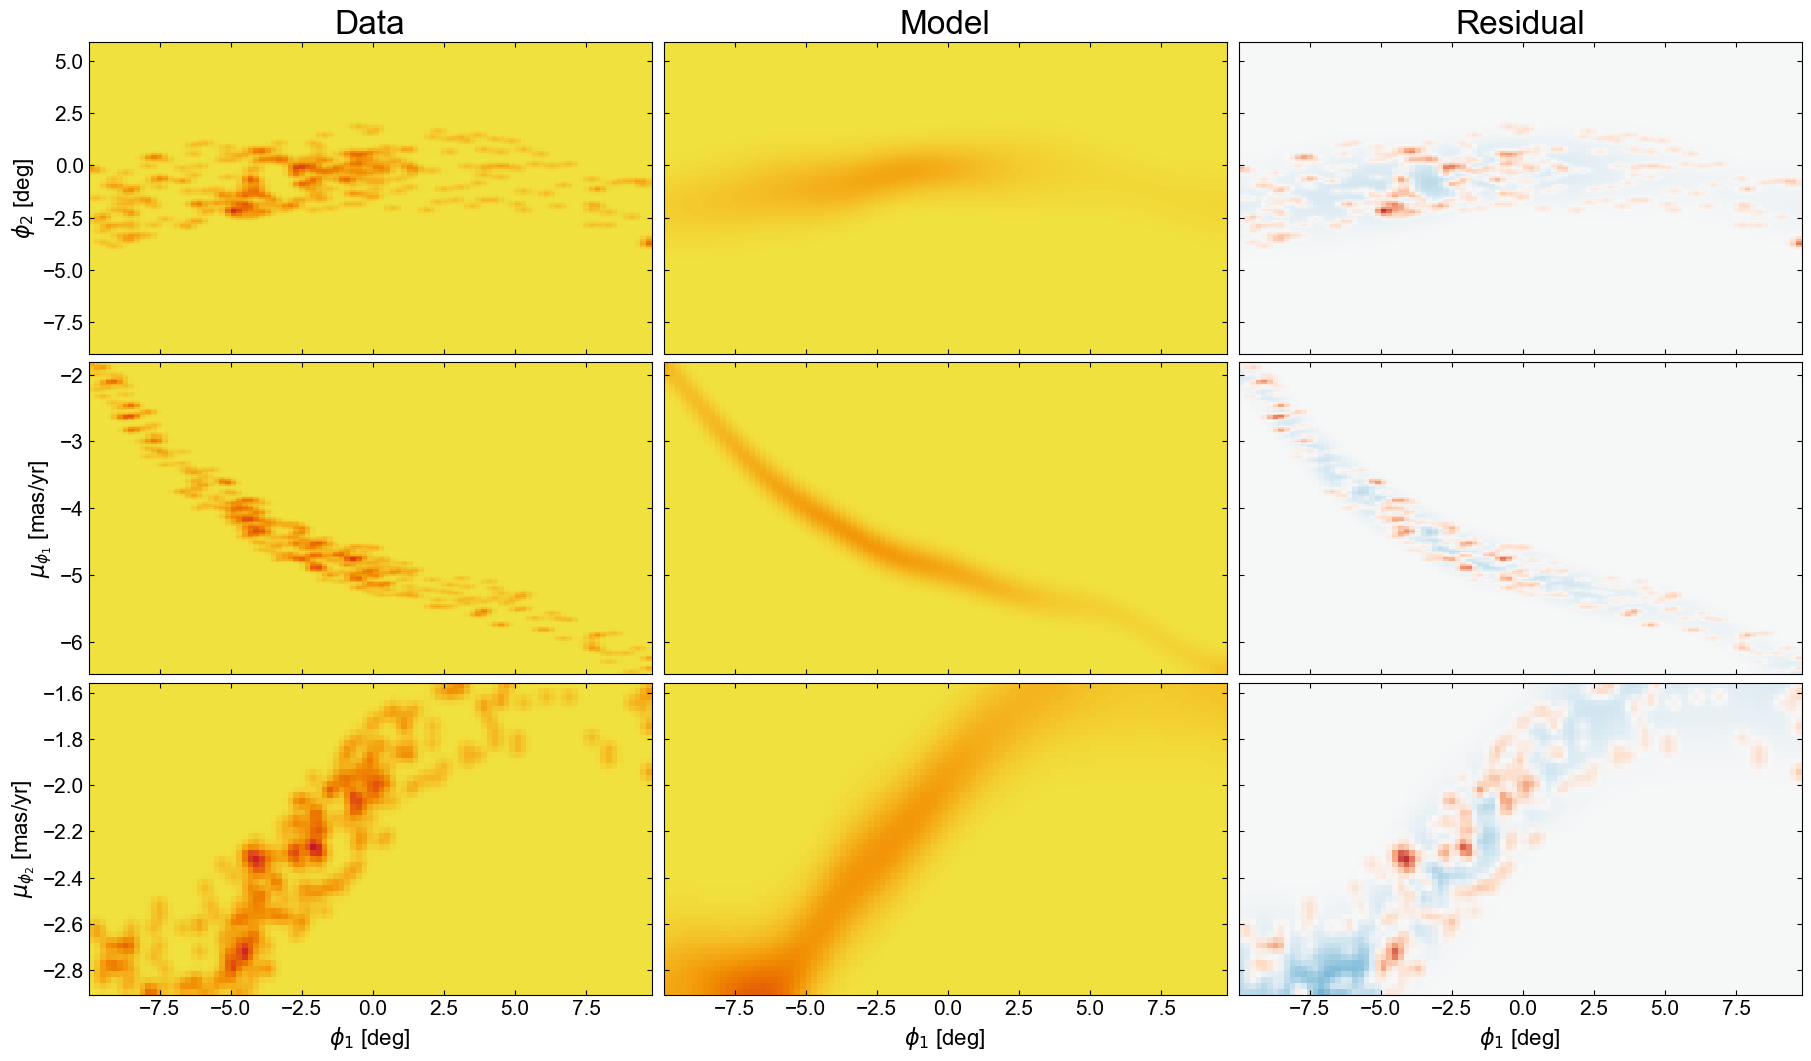

In [564]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=stream_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=2)
)
stream_opt.plot_model_projections(axes=axes[:, 1], label=False, 
                                  pcolormesh_kwargs=dict(rasterized=True,vmin=0, vmax=2))
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

# Mixture of Stream + Background (no off-track)

The problem with this is that the background model is not 2D so there is a lot of excess in certain parts that are being tracked as off-track features in this section.

In [565]:
Components = [StrModel, BkgModel]
MixModel_NoOff = make_mixture_model(StreamMixtureModel, Components)

In [566]:
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}
mix_params0['background']['ln_N'] = np.log(len(run_data['phi1']) - np.exp(mix_params0['stream']['ln_N']))

mix_init = MixModel_NoOff(mix_params0)

In [567]:
mix_opt_pars, info = MixModel_NoOff.optimize(
    data=run_data, init_params=mix_params0, use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096)
)

mix_opt = MixModel_NoOff(mix_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-1.57858283, dtype=float64, weak_type=True), success=True, status=0, iter_num=1537, hess_inv=LbfgsInvHessProduct(sk=[[-1.05856932e-04 -5.42100236e-04 -2.59391130e-04 ...  6.19988406e-05
   2.06404471e-06  3.80339405e-04]
 [ 1.19076101e-04  1.39036726e-05  2.64733779e-06 ...  2.24197220e-06
  -5.85657283e-06 -4.16600830e-06]
 [-1.95043335e-05  4.59728060e-05  2.86251064e-05 ... -2.67225411e-06
  -2.89287246e-06 -3.03165725e-05]
 ...
 [-1.67699343e-05 -1.36958749e-04  8.39733856e-05 ...  5.23017106e-06
   5.83630201e-06  1.14853517e-04]
 [-1.26429063e-05 -1.89195615e-04 -5.86207462e-06 ...  1.21946486e-05
   4.54602770e-06  1.48950110e-04]
 [ 6.58863346e-05 -1.76294158e-04 -6.52432280e-05 ...  1.48994269e-05
   1.37900928e-06  1.34736304e-04]], yk=[[-1.00395259e-04 -2.27849999e-07 -1.34547774e-05 ... -3.92233386e-07
   1.54688807e-07  4.60906761e-08]
 [ 1.15943558e-04  1.63476621e-09  9.74560921e-08 ... -1.26852106e-08
  -3.22911486e-08  1.87965999e-08]
 [

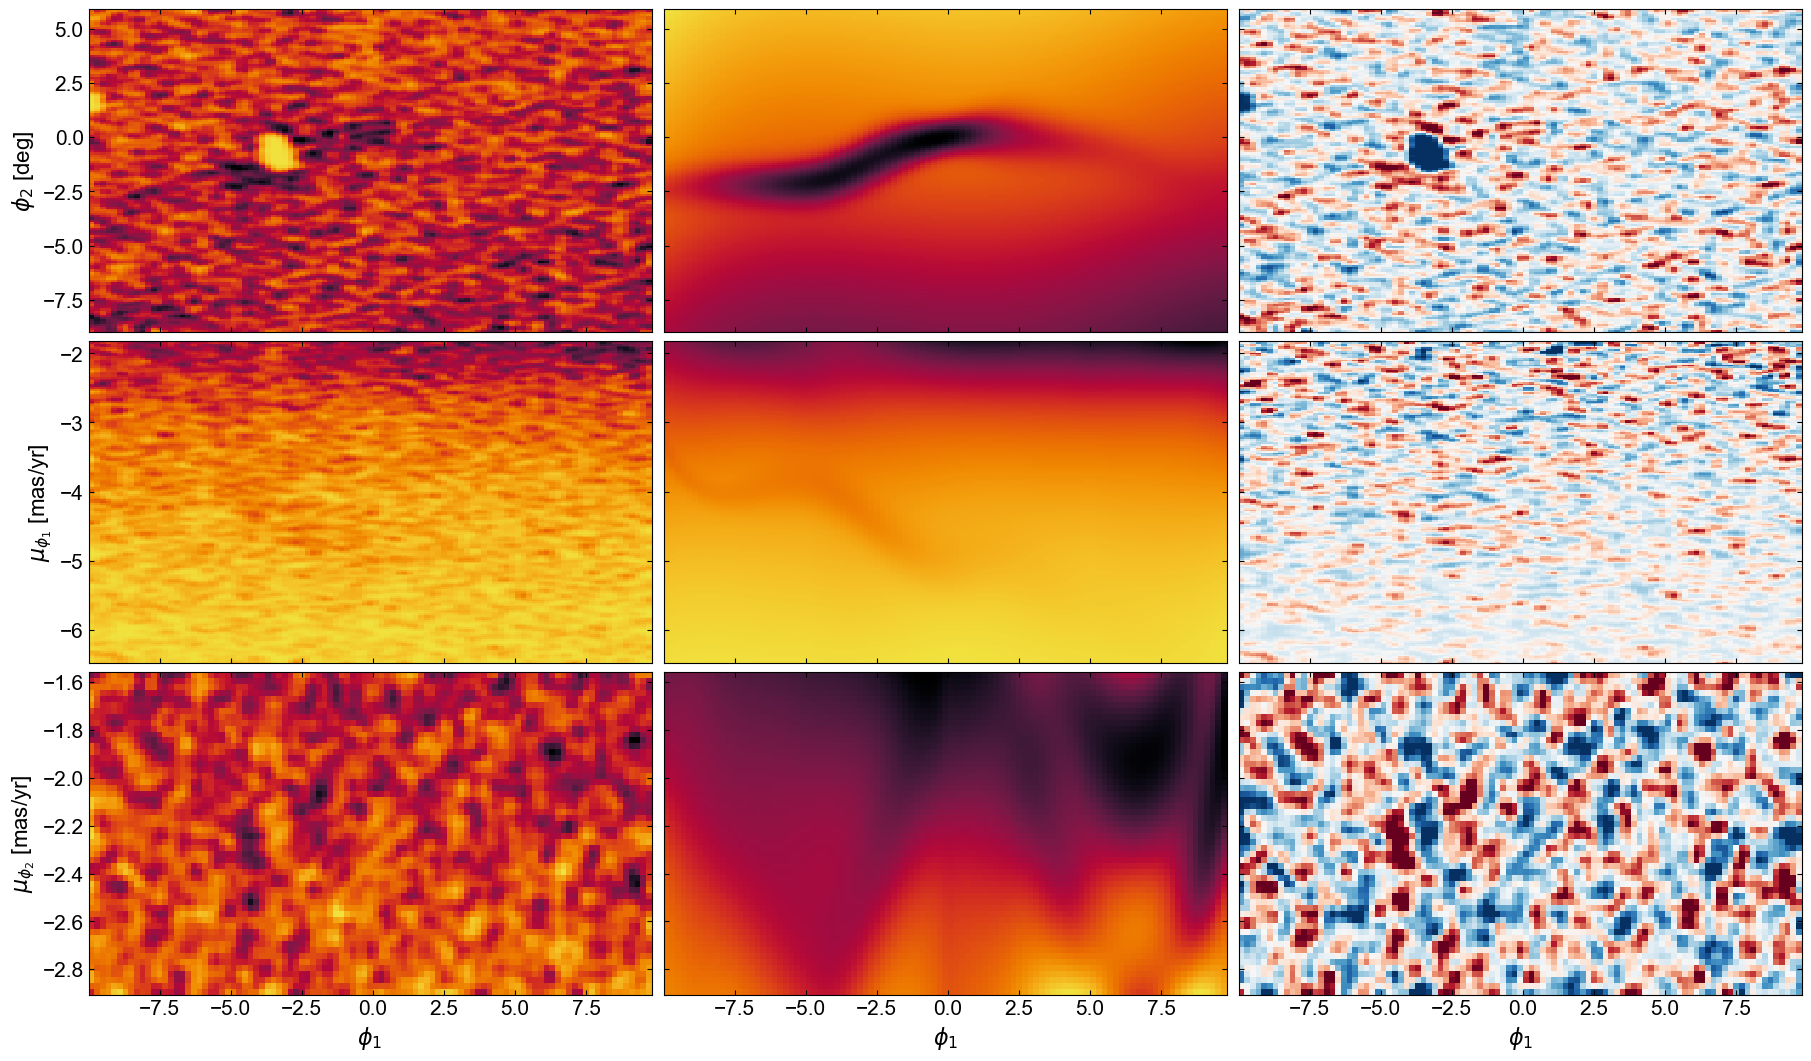

In [568]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=mix_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True)
)
mix_opt.plot_model_projections(axes=axes[:, 1], label=False,
                              pcolormesh_kwargs=dict(rasterized=True))
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu')
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [569]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['scripts.m92_init'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from scripts.m92_init import make_offtrack_model
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [570]:
OffModel = make_offtrack_model(OffTrackModel, p, cat, dens_steps=np.array([0.6,0.3]), StrModel=StrModel)

In [571]:
OffModel.dens_phi1_lim

(-9.999997074741202, 9.999999596103853)

In [572]:
offtrack_init_p = {
    "ln_N": np.log(50),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

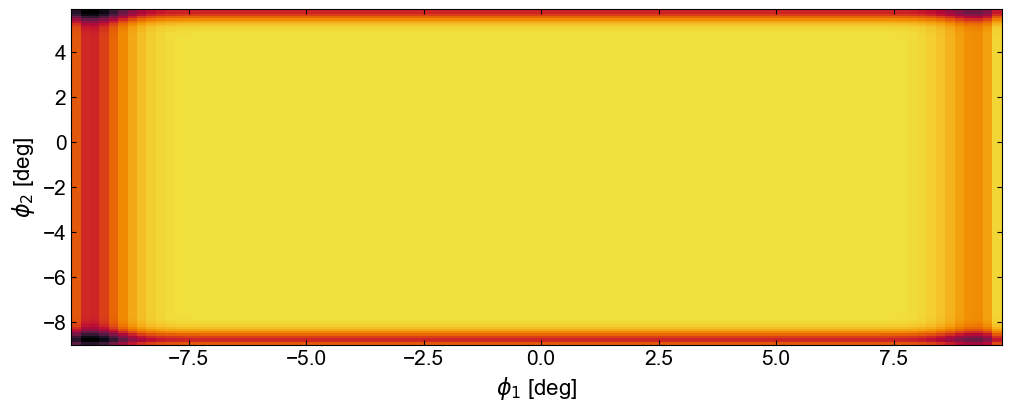

In [573]:
offtrack_init = OffModel(offtrack_init_p)
_ = offtrack_init.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [574]:
full_Components = [StrModel, BkgModel, OffModel]
full_mix_params0 = {
    "stream": mix_opt_pars['stream'],
    "background": mix_opt_pars['background'],
    "offtrack": offtrack_init_p,
}

MixModel = make_mixture_model(StreamMixtureModel, full_Components)

In [575]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = MixModel(
    full_mix_params0, tied_params=tied_params
)

In [576]:
full_mix_opt_pars, info = MixModel.optimize(
    data=run_data,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=False,
)

full_mix_opt = MixModel(full_mix_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(nan, dtype=float64, weak_type=True), success=False, status=2, iter_num=26, hess_inv=Array([[ 7.63424464e-01, -5.87603659e-03, -1.39696944e-01, ...,
         5.46317187e-01, -8.35582481e-01,  3.19912998e-02],
       [-5.87603659e-03,  1.00128642e+00,  2.95201394e-02, ...,
        -1.52716153e-01,  2.24006176e-01, -8.11185902e-03],
       [-1.39696944e-01,  2.95201394e-02,  2.21615444e+00, ...,
        -9.93005108e-01,  1.66203529e+00, -7.39459123e-02],
       ...,
       [ 5.46317187e-01, -1.52716153e-01, -9.93005108e-01, ...,
         3.16253556e+01, -4.37764910e+01,  1.52260850e+00],
       [-8.35582481e-01,  2.24006176e-01,  1.66203529e+00, ...,
        -4.37764910e+01,  6.36551112e+01, -2.18193251e+00],
       [ 3.19912998e-02, -8.11185902e-03, -7.39459123e-02, ...,
         1.52260850e+00, -2.18193251e+00,  1.07624245e+00]],      dtype=float64), num_fun_eval=Array(137, dtype=int32), num_jac_eval=Array(137, dtype=int32), num_hess_eval=Array(0, dtype=i

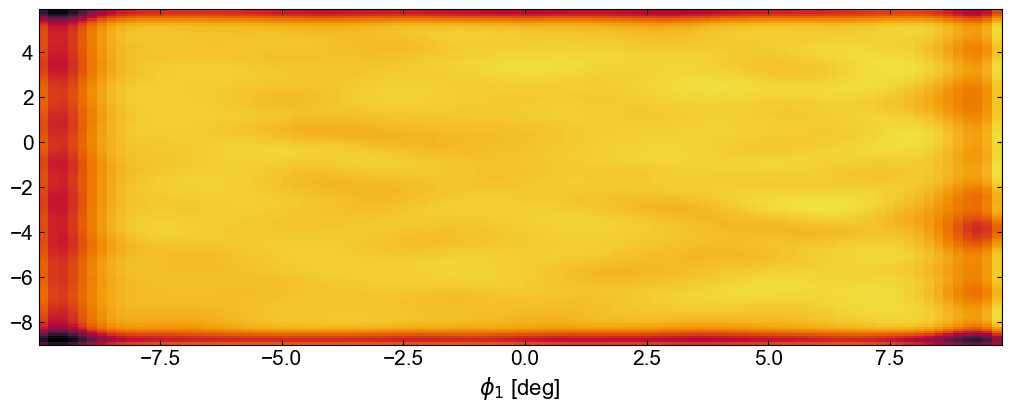

In [577]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
_,_,pcms = tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], label=False, 
    pcolormesh_kwargs=dict(cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$ [deg]', ylabel='$\\phi_2$ [deg]'>],
       dtype=object),
 [<matplotlib.collections.QuadMesh at 0x2562cd850>])

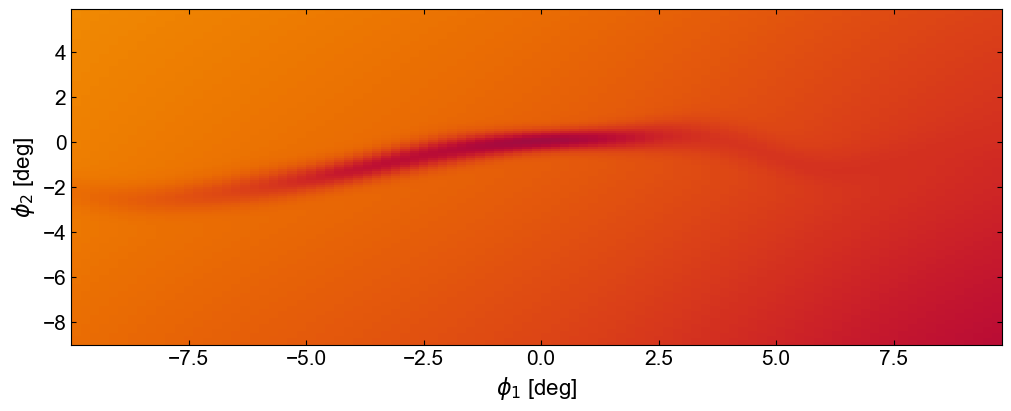

In [584]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(cmap='cmr.ember_r', vmin=0, vmax=5)
)

In [579]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]
stream_ll = stream_comp.ln_number_density(run_data)
bkg_ll = bkg_comp.ln_number_density(run_data)
offtrack_ll = offtrack_comp.ln_number_density(run_data)

#one way
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

#another way
# fg_comps = full_mix_nobkg_opt.components
# fg_ll_ = -np.log(fg_comps[0].get_N() + fg_comps[1].get_N()) + full_mix_nobkg_opt.ln_number_density(run_data)

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_41202/3429203970.py:1: RuntimeWarning: invalid value encountered in logaddexp
  final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_41202/3429203970.py:2: RuntimeWarning: invalid value encountered in logaddexp
  bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))


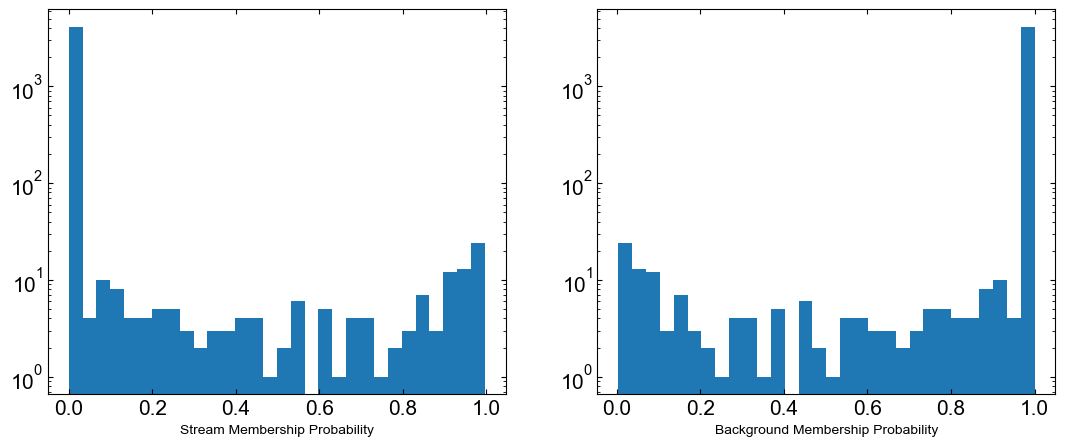

In [580]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=30)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability')

ax2.hist(bkg_prob, bins=30)
ax2.set_xlabel('Background Membership Probability')
ax2.set_yscale('log')
plt.show()

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

Text(0, 0.5, '$\\phi_2$')

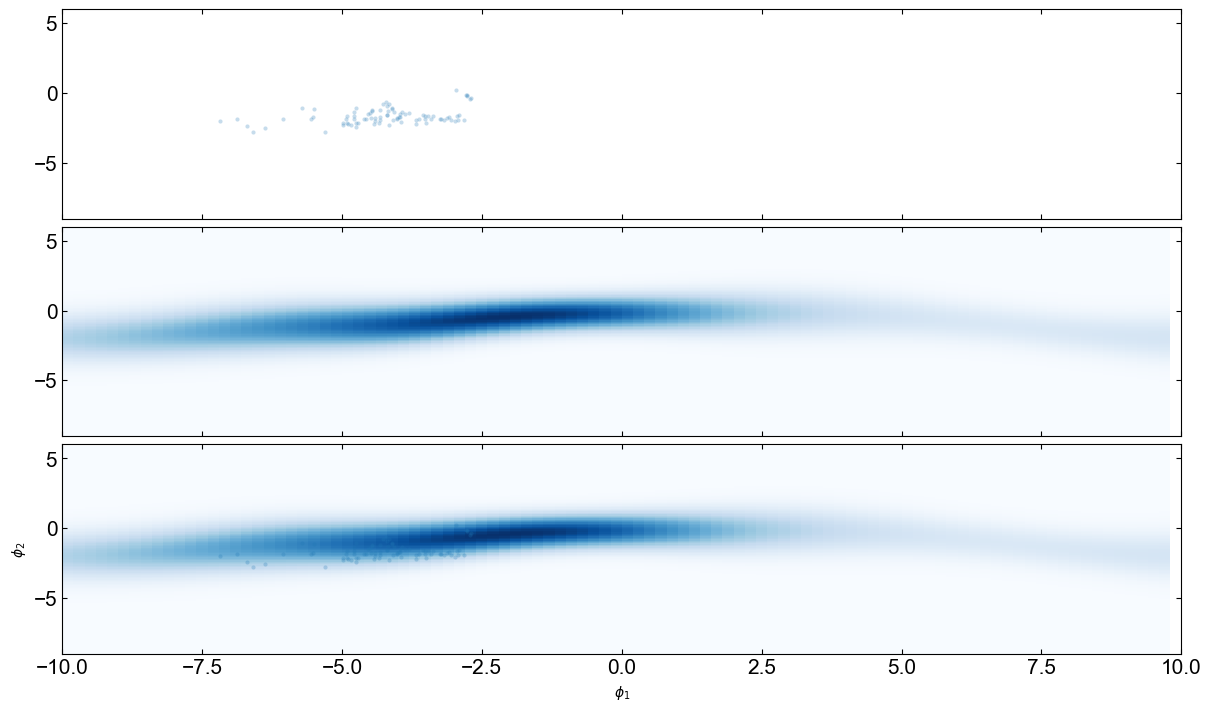

In [589]:
threshold = (final_memb_prob>0.5)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-10, 10)
ax.set_ylim(-9, 6)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")